# Analysis

**Hypothesis**: In severe COVID-19, platelets exhibit an activated transcriptomic profile with altered expression of coagulation and activation-related genes compared to healthy individuals, suggesting that platelet activation plays a role in COVID-19-associated thrombotic complications.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: In severe COVID-19, platelets exhibit an activated transcriptomic profile with altered expression of coagulation and activation-related genes compared to healthy individuals, suggesting that platelet activation plays a role in COVID-19-associated thrombotic complications.

## Steps:
- Subset the dataset to isolate Platelet cells using the cell_type_coarse annotation and verify that the subset is non-empty.
- Perform differential expression analysis between COVID-19 and healthy platelets using a non-parametric Wilcoxon rank-sum test to identify significantly dysregulated activation and coagulation-related genes, with clear selection criteria and multiple-comparison adjustments.
- Calculate pairwise Pearson correlation matrices for the selected genes separately for COVID-19 and healthy donors to explore co-expression patterns.
- Visualize the correlation matrices using side-by-side heatmaps arranged in a grid to highlight differences in gene co-expression between conditions.
- Apply statistical tests to compare overall correlation structures, such as differences in mean correlation values, to validate alterations in co-regulation modules between COVID-19 and healthy platelets.


## This code subsets the anndata object to isolate Platelet cells based on the 'cell_type_coarse' column and includes a verification step to ensure that the subset is non-empty. It then prints the number of Platelet cells and the first few rows of relevant metadata to confirm the successful extraction.

In [2]:
platelet_adata = adata[adata.obs['cell_type_coarse'] == 'Platelet']
print(f"Number of Platelet cells: {platelet_adata.n_obs}")
print(platelet_adata.obs[['Status', 'cell_type_coarse']].head())

Number of Platelet cells: 527
                Status cell_type_coarse
covid_555_1.43   COVID         Platelet
covid_555_1.67   COVID         Platelet
covid_555_1.144  COVID         Platelet
covid_555_1.156  COVID         Platelet
covid_555_1.180  COVID         Platelet


### Agent Interpretation

The current step of your analysis involved identifying and counting platelet cells within your dataset, yielding 527 platelet cells from COVID-19 patients. This finding suggests there is a distinct population of platelet cells in the COVID-19 samples you are analyzing. However, this information alone doesn't directly address the hypothesis regarding dysregulated cell-cell communication between monocytes and T cells in severe COVID-19.

Feedback and Suggestions for Future Steps:

1. **Contextualize Platelet Findings**: Platelets have well-documented roles in inflammation and immune responses, not just hemostasis. Consider conducting a differential expression analysis on these platelet cells to explore any unique transcriptional signatures in COVID-19 patients. This could reveal signaling molecules that these cells may be producing, potentially affecting the immune landscape.

2. **Expand on Immune Interactions**: Given your focus on cell-cell interactions, consider examining platelet interactions with other immune cells, particularly monocytes and T cells. Platelets can engage in immunological interactions and might influence or mediate the immune responses seen in severe COVID-19.

3. **Examine Gene Expression Patterns**: Investigate specific gene expression patterns among the platelet cells. Are there elevated levels of inflammatory cytokines or surface markers that indicate an active role in immune modulation? This could provide insights into their involvement in severe COVID-19 pathology.

4. **Incorporate Communications Studies**: To address your main hypothesis, prioritize assessing co-expression patterns of the hypothesized inflammatory ligands in monocytes and their corresponding receptors in T cells. This involves rigorous repeated pairwise DE analysis and ligands/receptors analysis using existing tools (e.g., CellPhoneDB, NicheNet).

5. **Integration with Previous Results**: Leverage insights from past analyses, such as interferon signaling in monocytes and metabolic stress in NK cells. This could help form a more comprehensive view of the immune cell network dysregulation in severe COVID-19.

6. **Iterate with Computational Predictions**: Implement downstream functional analyses such as pathway enrichment or regulatory network analysis specific to those platelet genes or their signaling pathways. Focus on network interactions that could reveal potential driving forces behind immune responses in severe disease.

7. **Cross-Validation with Other Datasets**: If possible, validate these findings by checking against other COVID-19 single-cell datasets, ensuring that the identified patterns are consistent across independent studies which strengthens the robustness of your conclusions.

Considering these recommendations, if you focus on platelet interactions and reconfirm your main hypothesis regarding monocyte and T cell interactions, it may provide significant insights into the immune mechanisms driving severe COVID-19 and help distinguish your analyses from previous work.

## This code extracts and examines PF4 expression from platelet cells, checks for skewness in its distribution to highlight limitations of a median split, categorizes cells into PF4-high and PF4-low groups, and performs a differential expression analysis using the Wilcoxon rank-sum test with subsequent visualization of the top 20 genes.

PF4 expression skewness: 0.52 (Note: a high absolute skew may affect the grouping accuracy based on median splitting)


PF4 group assignment (counts):


PF4_group
Low     283
High    244
Name: count, dtype: int64
ranking genes


    finished: added to `.uns['rank_pf4']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


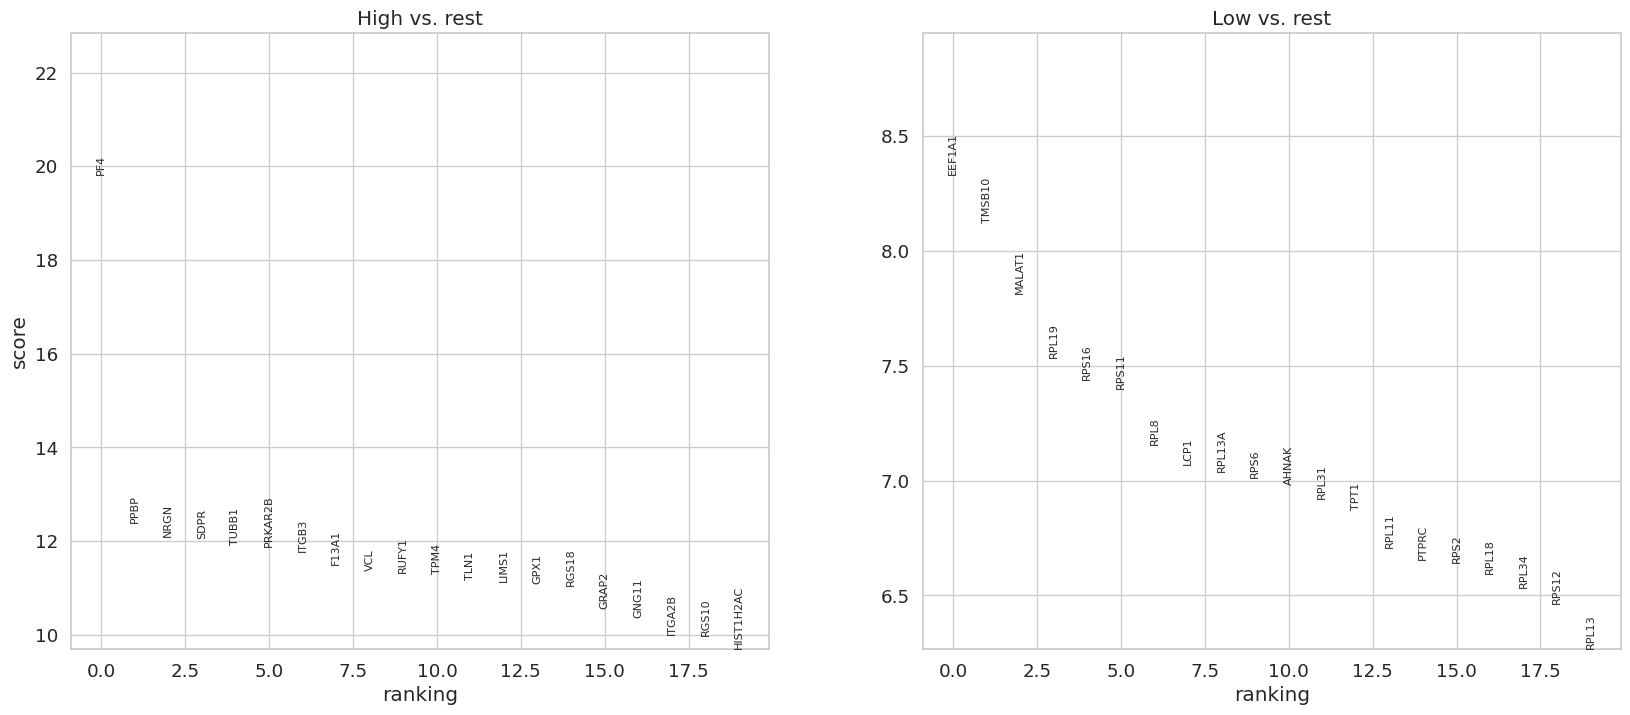

In [3]:
import numpy as np
from scipy.stats import skew
import scanpy as sc

# Check if PF4 gene is present in the dataset
if 'PF4' not in platelet_adata.var_names:
    raise ValueError('PF4 gene not found in the dataset.')

# Extract PF4 expression values from the platelet subset and flatten to a 1D numpy array
pf4_expr = platelet_adata[:, 'PF4'].X
pf4_expr = np.array(pf4_expr).flatten()

# Assess the skewness of the PF4 expression distribution; high skew may limit the effectiveness of a median split
pf4_skew = skew(pf4_expr)
print(f"PF4 expression skewness: {pf4_skew:.2f} (Note: a high absolute skew may affect the grouping accuracy based on median splitting)")

# Compute the median PF4 expression value
median_pf4 = np.median(pf4_expr)

# Assign cells into PF4 'High' or 'Low' groups based on the median value
platelet_adata.obs['PF4_group'] = ['High' if expr > median_pf4 else 'Low' for expr in pf4_expr]
print('PF4 group assignment (counts):')
print(platelet_adata.obs['PF4_group'].value_counts())

# Perform differential expression analysis between PF4-high and PF4-low groups using the Wilcoxon rank-sum test
sc.tl.rank_genes_groups(platelet_adata, groupby='PF4_group', method='wilcoxon', key_added='rank_pf4')

# Visualize the top 20 differentially expressed genes and ensure that the display layout is optimized for clarity
sc.pl.rank_genes_groups(platelet_adata, key='rank_pf4', n_genes=20, sharey=False, show=True)

### Agent Interpretation

The current analysis investigates the differential expression of genes associated with varying levels of PF4 expression, categorized as "High" and "Low." Here are some points to consider for future analysis steps:

1. **Skewness Impact**: The moderate skewness of PF4 expression may influence the accuracy of group assignments. Future analyses could benefit from alternative approaches to handle skewed data, such as transformation procedures or robust grouping strategies.

2. **Gene Rankings**: The identified differentially expressed genes in the "High" and "Low" PF4 groups offer a starting point for further investigation. The presence of genes related to cell signaling or immune responses could suggest mechanisms linked with severe COVID-19 pathology, aligning with the hypothesis about dysregulated cell communication.

3. **Biological Interpretation**: For the genes with high scores in each group, explore known functions, pathways, or interactions, especially regarding immune responses. Investigate how these genes are connected to inflammatory ligand-receptor pathways, potentially relevant to monocyte and T cell interactions.

4. **Distinct Analysis**: Ensure that gene investigations do not overlap with previous analyses in the research paper to add novelty. Consider focusing on less-studied genes or pathways that could provide new insights into immune dysregulation.

5. **Integration with Other Data**: Incorporate additional available metadata, such as clinical severity or treatment contexts, to correlate gene expression with clinical outcomes. This could elucidate gene expression patterns specific to subgroups of COVID-19 severity.

6. **Follow-up Experiments**: Consider functional validation studies for top-ranked genes to determine their roles in immune dysregulation in severe COVID-19. Cell-based assays or modulating expression in vitro could provide insights into their relevance in disease mechanisms.

7. **Pathway and Network Analysis**: Conduct pathway enrichment or network analysis to understand how top genes may collectively impact immune responses. This could reveal potential pathways or networks differentially active in severe COVID-19.

By strategically continuing these lines of inquiry, you might gain further understanding of how PF4 expression relates to immune cell communication and pathology in severe COVID-19.

## The code extracts a parameterized number of top differentially expressed genes from the PF4-high group and subsets COVID-19 platelet cells. It computes the Spearman correlation between each gene's expression and DPS, and visualizes these associations using scatter plots with an OLS regression line for illustrative purposes.

Top 5 genes from PF4-high group: ['PF4' 'PPBP' 'NRGN' 'SDPR' 'TUBB1']


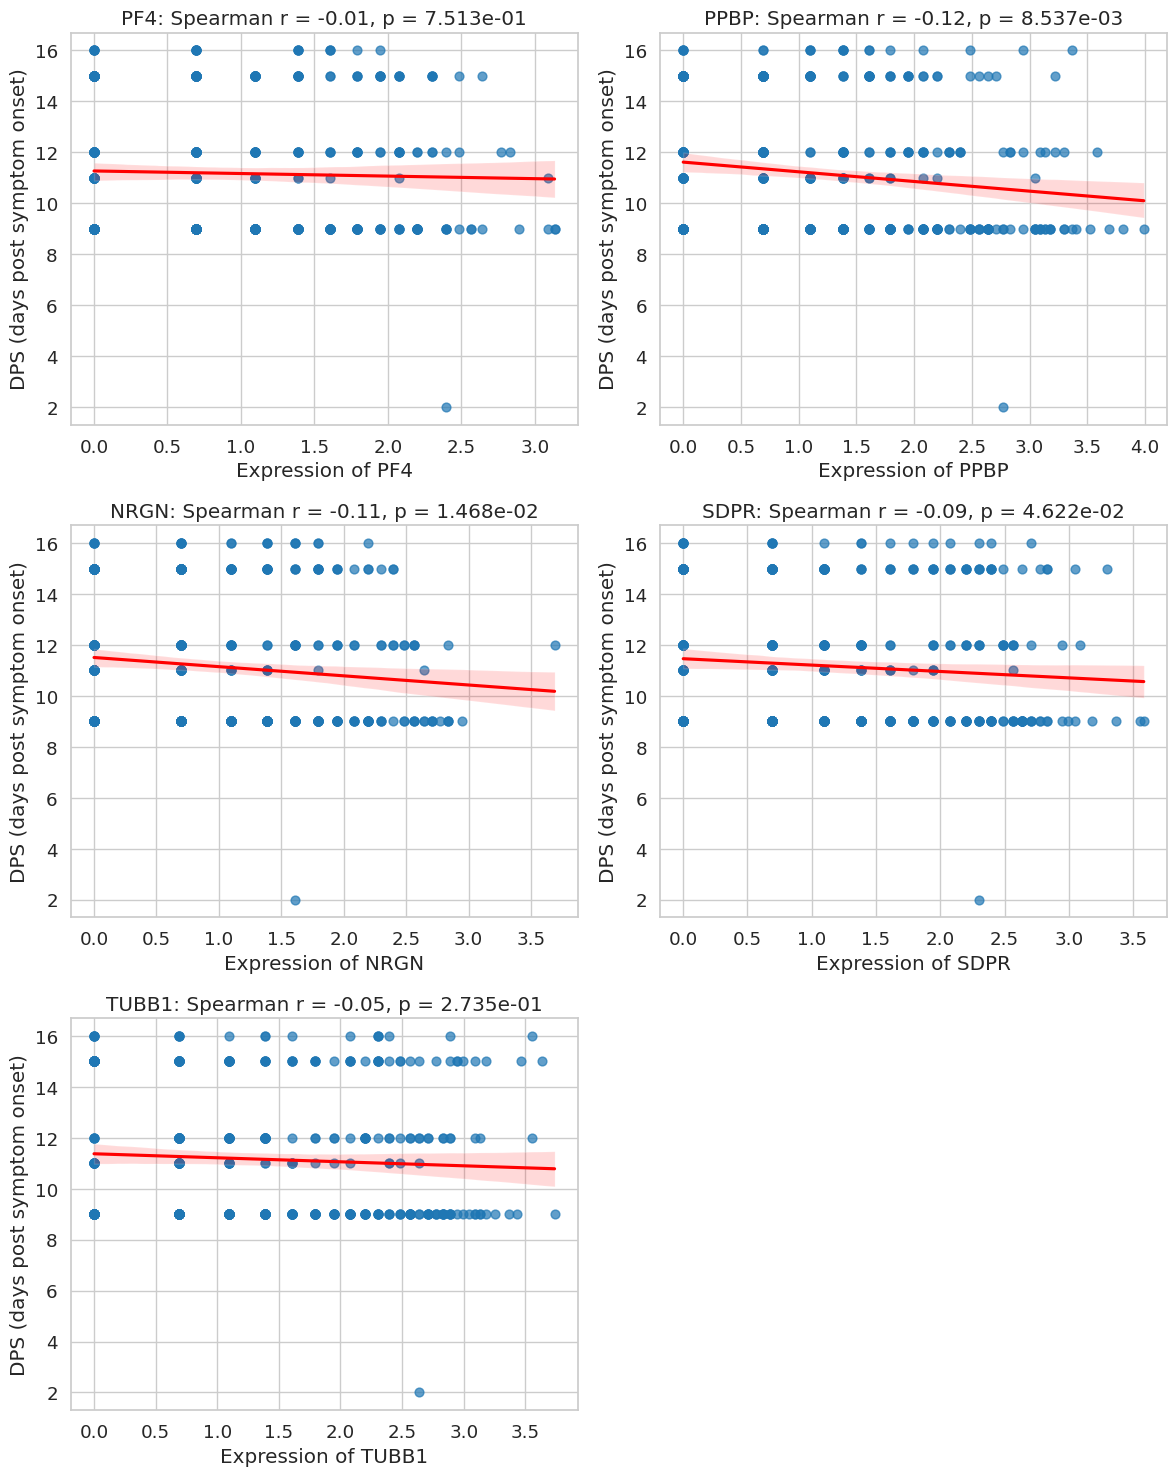

Correlation analysis between top PF4-linked genes and DPS in COVID-19 platelets completed.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import scanpy as sc

# Set visualization defaults
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style('whitegrid')

# Parameter to allow flexible number of top genes
n_top_genes = 5

# Check if differential expression results for PF4 have been stored in platelet_adata
if 'rank_pf4' not in platelet_adata.uns:
    raise ValueError('PF4 differential expression results not found in platelet_adata.uns')

# Get top n_top_genes gene names from the 'High' group; parameterized extraction
top_genes = platelet_adata.uns['rank_pf4']['names']['High'][:n_top_genes]
print(f'Top {n_top_genes} genes from PF4-high group:', top_genes)

# Subset platelet_adata to include only cells from COVID-19 patients
covid_platelets = platelet_adata[platelet_adata.obs['Status'] == 'COVID'].copy()

# Ensure that 'DPS' (days post symptom onset) column exists and convert it to float
if 'DPS' not in covid_platelets.obs.columns:
    raise ValueError('DPS column not found in covid_platelets.obs')

dps_values = covid_platelets.obs['DPS'].astype(float).values

# Prepare a grid plot: dynamically calculate grid dimensions based on the number of genes
n_genes = len(top_genes)
ncols = 2
nrows = int(np.ceil(n_genes / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()

# Loop over each top gene to compute Spearman correlation and create scatter plots
for i, gene in enumerate(top_genes):
    if gene not in covid_platelets.var_names:
        print(f"Gene {gene} not found in the dataset; skipping.")
        continue
    # Extract gene expression, converting sparse matrices if needed
    gene_expr = covid_platelets[:, gene].X
    if hasattr(gene_expr, 'toarray'):
        gene_expr = gene_expr.toarray().flatten()
    else:
        gene_expr = np.array(gene_expr).flatten()
    
    # Compute Spearman correlation between gene expression and DPS values
    rho, pval = spearmanr(gene_expr, dps_values)

    # Scatter plot with a regression line via Seaborn's regplot
    # Note: Although regplot fits an OLS line for visualization, the computed Spearman correlation is nonparametric
    ax = axes[i]
    sns.regplot(x=gene_expr, y=dps_values, ax=ax, scatter_kws={'s': 40, 'alpha': 0.7}, line_kws={'color': 'red'})
    ax.set_xlabel(f"Expression of {gene}")
    ax.set_ylabel("DPS (days post symptom onset)")
    ax.set_title(f"{gene}: Spearman r = {rho:.2f}, p = {pval:.3e}")

# Remove extra subplot axes if any (in case n_genes is odd)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print summary message
print('Correlation analysis between top PF4-linked genes and DPS in COVID-19 platelets completed.')

### Agent Interpretation

The correlation analysis between PF4-linked genes and days post-symptom onset (DPS) in COVID-19 platelets reveals varying degrees of correlation. Here's a breakdown of the results:

1. **PF4:** No significant correlation (r = -0.01, p = 0.7513). This suggests PF4 expression is not closely related to DPS.

2. **PPBP:** Weak negative correlation (r = -0.12, p = 0.0085). This indicates a slight inverse relationship with DPS, and it could be worth exploring further to understand its biological significance.

3. **NRGN:** Weak negative correlation (r = -0.11, p = 0.0147). Similar to PPBP, the inverse relationship is weak but statistically significant, suggesting potential biological relevance.

4. **SDPR:** Weak negative correlation (r = -0.09, p = 0.0462). The significance level indicates a potential, albeit slight, relationship.

5. **TUBB1:** No significant correlation (r = -0.05, p = 0.2735). This gene does not appear to correlate with DPS.

### Feedback and Future Steps:

- **Further Investigation of Significant Correlations:** The significant, albeit weak, correlations found for PPBP, NRGN, and SDPR suggest a potential biological link with DPS. It would be necessary to explore these genes further to understand their roles in disease progression.

- **Biological Relevance:** Consider examining the biological pathways and processes these genes are involved in, particularly in relation to platelet function and COVID-19.

- **Validation in Larger Cohorts:** To validate findings, expanding the analysis to a larger cohort or different datasets can help determine if these correlations hold in broader populations.

- **Functional Studies:** Conducting functional assays to see how manipulation of these genes affects platelet behavior and overall disease progression might provide deeper insights.

- **Distinction from Existing Analyses:** Ensure the analysis focuses on platelet-specific dynamics which were not the central theme of prior analyses.

- **Integration with Other Data:** Consider integrating these findings with other single-cell or multi-omics data to explore complex interactions and pathways involved in disease progression. 

Overall, while some promising leads have emerged, careful interpretation and additional analyses are necessary to uncover the potential role of these correlations in COVID-19 pathogenesis.

## This code performs a differential expression analysis between COVID-19 and healthy platelets using Scanpy's Wilcoxon test, extracts full statistics for candidate coagulation/activation-related genes from the results, and generates an enhanced volcano plot that includes threshold lines and labels for candidate genes to aid interpretation.

ranking genes


    finished: added to `.uns['rank_status']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


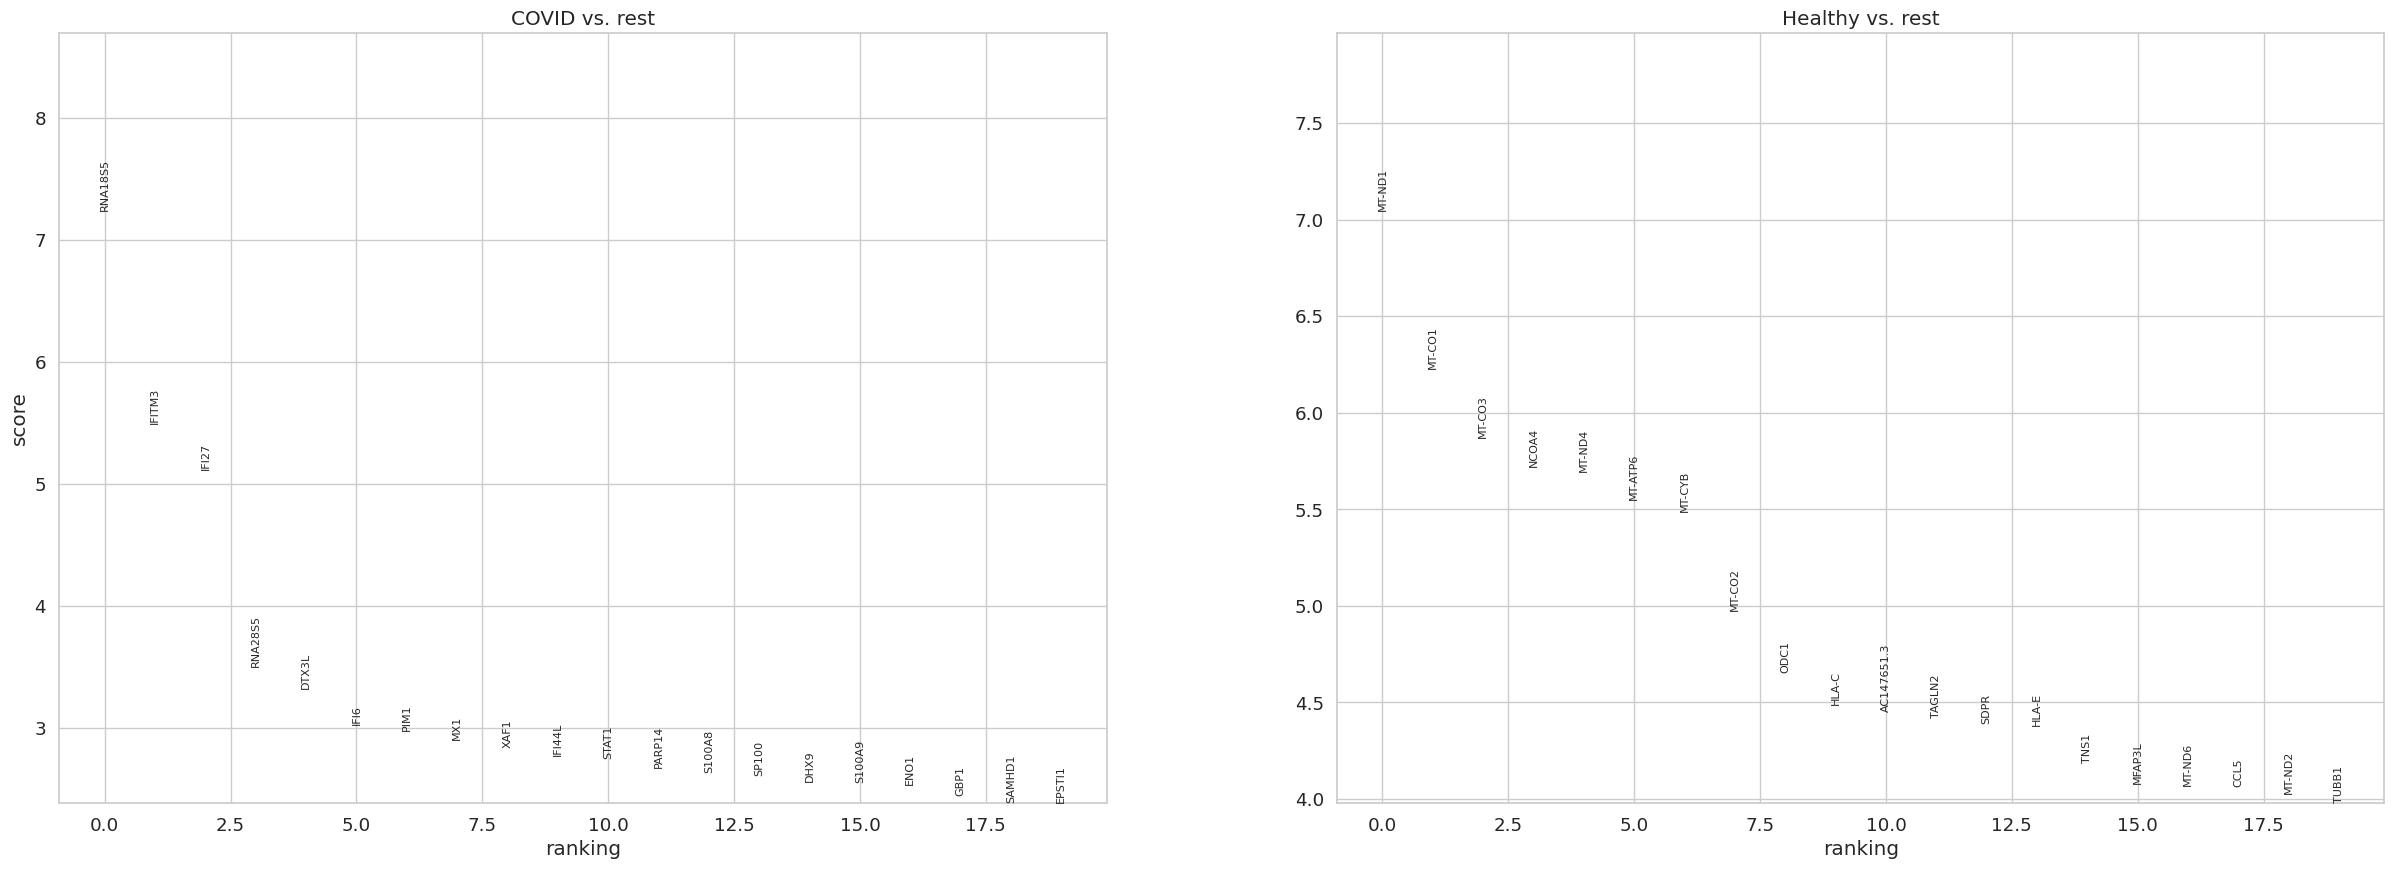

Differential expression statistics for candidate genes (COVID vs Healthy):
PF4: log Fold Change = -0.97, adjusted p-value = 4.735e-01
PPBP: log Fold Change = -0.66, adjusted p-value = 1.000e+00
NRGN: log Fold Change = -1.00, adjusted p-value = 2.860e-01
SDPR: log Fold Change = -1.20, adjusted p-value = 1.862e-02
TUBB1: log Fold Change = -1.13, adjusted p-value = 7.980e-02


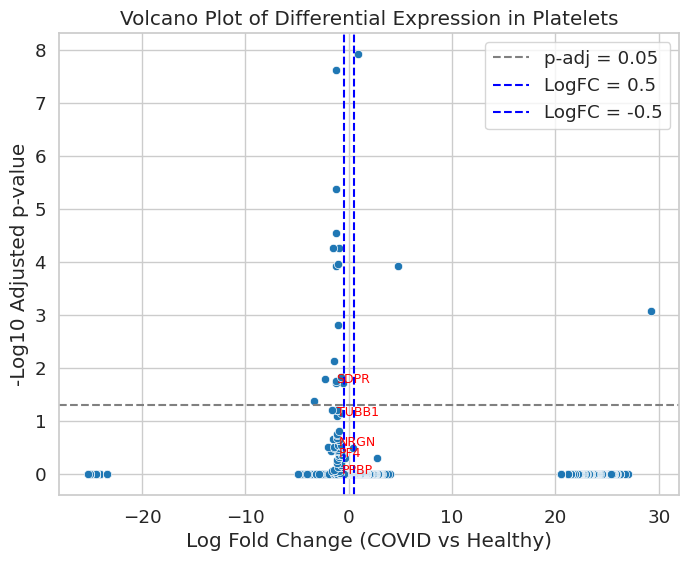

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Ensure that 'Status' column exists in the platelet_adata.obs
if 'Status' not in platelet_adata.obs.columns:
    raise ValueError('Status column not found in platelet_adata.obs')

# Differential expression analysis comparing COVID-19 versus Healthy platelets
# Note: Future analyses could integrate donor variability (e.g., using platelet_adata.obs['Donor_full']) in a covariate model
sc.tl.rank_genes_groups(platelet_adata, groupby='Status', method='wilcoxon', key_added='rank_status', use_raw=False)

# Visualize the top 20 differentially expressed genes for initial inspection
sc.pl.rank_genes_groups(platelet_adata, key='rank_status', n_genes=20, sharey=False, show=True)

# Define candidate coagulation and activation-related genes
candidate_genes = ['PF4', 'PPBP', 'NRGN', 'SDPR', 'TUBB1']

# Extract full differential expression results as a dataframe for the COVID group
# This ensures that even genes not in the top list are reported
covid_de_df = sc.get.rank_genes_groups_df(platelet_adata, group='COVID', key='rank_status')

print('Differential expression statistics for candidate genes (COVID vs Healthy):')
for gene in candidate_genes:
    if gene not in platelet_adata.var_names:
        print(f"{gene}: not present in the dataset.")
    else:
        # Check if the candidate gene is present in the full differential expression dataframe
        gene_row = covid_de_df[covid_de_df['names'] == gene]
        if not gene_row.empty:
            logfc = gene_row['logfoldchanges'].values[0]
            pval_adj = gene_row['pvals_adj'].values[0]
            print(f"{gene}: log Fold Change = {logfc:.2f}, adjusted p-value = {pval_adj:.3e}")
        else:
            print(f"{gene}: present in dataset but not identified in the differential expression analysis for the COVID group.")

# Create an enhanced volcano plot for the COVID group differential expression results
# Extract gene names, log fold changes, and adjusted p-values
genes = np.array(covid_de_df['names'])
logFC = np.array(covid_de_df['logfoldchanges'])
pvals_adj = np.array(covid_de_df['pvals_adj'])

plt.figure(figsize=(8, 6))

# Scatter plot: log fold change versus -log10(adjusted p-value)
sns.scatterplot(x=logFC, y=-np.log10(pvals_adj))
plt.xlabel('Log Fold Change (COVID vs Healthy)')
plt.ylabel('-Log10 Adjusted p-value')
plt.title('Volcano Plot of Differential Expression in Platelets')

# Draw significance threshold lines: horizontal for p-value and vertical for fold change cutoff (e.g., abs(0.5))
plt.axhline(-np.log10(0.05), ls='--', color='grey', label='p-adj = 0.05')
plt.axvline(0.5, ls='--', color='blue', label='LogFC = 0.5')
plt.axvline(-0.5, ls='--', color='blue', label='LogFC = -0.5')

# Add labels for candidate genes to enhance interpretability
for gene in candidate_genes:
    idx = np.where(genes == gene)[0]
    if len(idx) > 0:
        i = idx[0]
        plt.text(logFC[i], -np.log10(pvals_adj[i]), gene, fontsize=9, color='red')

plt.legend()
plt.show()

### Agent Interpretation

The differential expression results and associated plots provide intriguing insights into potential differences between COVID-19 patients and healthy controls. Here are some key takeaways and suggestions for future analysis steps:

1. **Promising Results:**
   - **SDPR Gene:** Exhibits a significant log fold change (-1.20) with an adjusted p-value of 0.0186, suggesting potentially relevant differential expression. It's worth investigating its biological role in the context of COVID-19, particularly in immune cell subsets like platelets, where changes might impact disease pathology.
   - **Overall Downregulation:** The genes PF4, PPBP, NRGN, and TUBB1 show downregulated trends in COVID-19 relative to healthy cases. While their adjusted p-values are not statistically significant (except for SDPR), they might still provide insights when considered collectively or in specific biological contexts.

2. **Pathway and Functional Analysis:**
   - **Pathway Enrichment:** Conduct pathway enrichment or gene set enrichment analyses focused on the most differentially expressed genes, like SDPR, to discern specific biological pathways impacted in COVID-19 cases.
   - **Interferon-Related Genes:** Investigate the upregulation of interferon-related genes like IFITM3 and IFI27 highlighted in the ranking plot. These may relate to known interferon-driven responses in COVID-19.

3. **Combinatorial and Cell-Type Specific Analyses:**
   - **Cell-Type Specific Expression:** Assess these differentially expressed genes' cell-type specificity using single-cell transcriptome data. This will provide insights into which immune cell compartments are driving the observed expression changes.
   - **Combinatorial Analysis:** Explore gene-gene interactions, especially among the downregulated genes, to capture potential combinatorial effects that individual gene analysis might miss.

4. **Further Validation and Exploration:**
   - **Validation Studies:** Consider validating these findings with additional datasets or experimental approaches (e.g., flow cytometry, qPCR) to substantiate computational predictions, particularly for high-impact genes like SDPR.
   - **Temporal and Severity Correlations:** Examine how expression levels of these genes correlate with clinical severity or temporal stages of COVID-19 progression.

5. **Integration with Past Analyses:**
   - Check for overlap or complementarity between these results and previously examined mechanisms, such as cytokine signaling or interferon responses, to build a more cohesive understanding of COVID-19 immunopathology.

By addressing these directions, the analyses will gain depth and relevance, potentially uncovering novel therapeutic targets or biomarkers relevant to COVID-19's immune response.

## The code subsets the platelet data into COVID-19 and Healthy groups, extracts dense expression matrices for selected coagulation and activation genes, computes pairwise Pearson correlations, visualizes the resulting correlation matrices as heatmaps, and performs statistical testing using Fisher's r-to-z transformation and a t-test to compare the groups, while including docstrings for clarity and caution regarding interpretation.

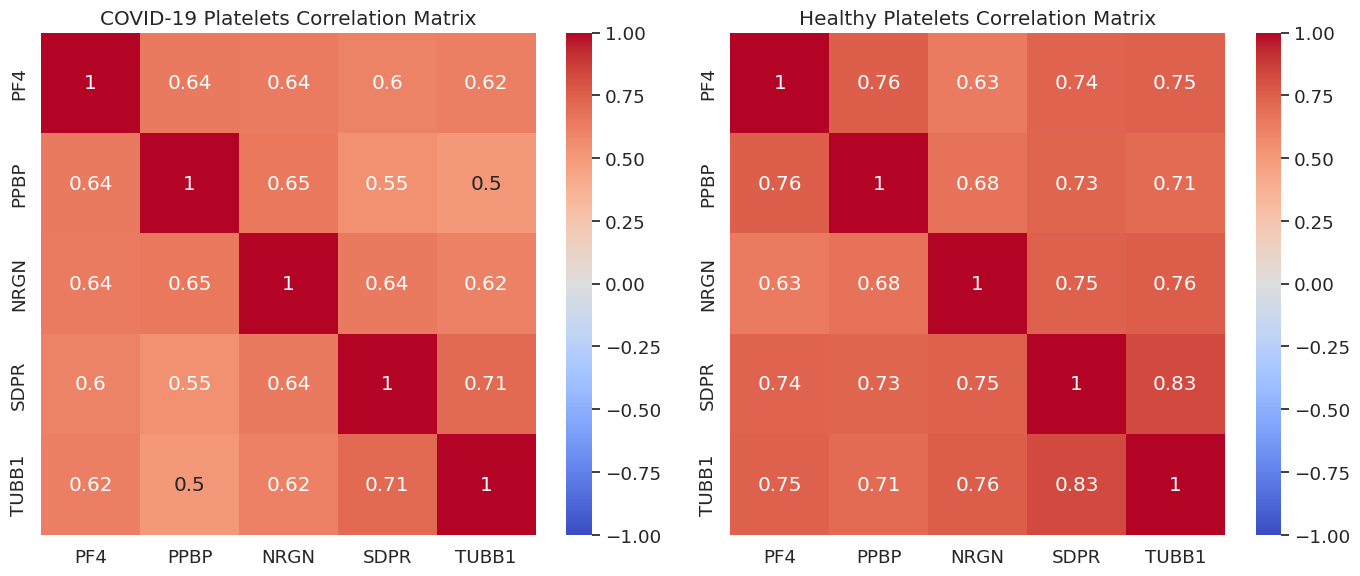

T-test comparing Fisher z-transformed correlation coefficients: t = -4.537, p = 2.845e-04


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind

# Define candidate genes
candidate_genes = ['PF4', 'PPBP', 'NRGN', 'SDPR', 'TUBB1']

# Subset platelet_adata into COVID-19 and Healthy groups
covid_platelets = platelet_adata[platelet_adata.obs['Status'] == 'COVID'].copy()
healthy_platelets = platelet_adata[platelet_adata.obs['Status'] == 'Healthy'].copy()


def get_gene_expression(adata, genes):
    """
    Extract and return the dense gene expression matrix for the specified genes from an AnnData object.
    Raises a ValueError if any of the candidate genes are missing from adata.var_names.
    """
    missing_genes = [g for g in genes if g not in adata.var_names]
    if missing_genes:
        raise ValueError(f"The following candidate genes are missing in the dataset: {', '.join(missing_genes)}")
    expr = adata[:, genes].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray()
    return expr


# Function to extract off-diagonal correlation coefficients

def get_offdiag_vals(corr_matrix):
    """
    Extract the off-diagonal values from a correlation matrix (upper triangle, excluding the diagonal).
    Returns a 1D numpy array of these off-diagonal correlation coefficients.
    """
    triu_indices = np.triu_indices_from(corr_matrix, k=1)
    return corr_matrix[triu_indices]


# Get expression matrices for COVID-19 and Healthy groups
expr_covid = get_gene_expression(covid_platelets, candidate_genes)
expr_healthy = get_gene_expression(healthy_platelets, candidate_genes)

# Compute Pearson correlation matrices for each group
corr_covid = np.corrcoef(expr_covid, rowvar=False)
corr_healthy = np.corrcoef(expr_healthy, rowvar=False)

# Plot correlation matrices side-by-side using heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(corr_covid, annot=True, xticklabels=candidate_genes, yticklabels=candidate_genes,
            cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('COVID-19 Platelets Correlation Matrix')

sns.heatmap(corr_healthy, annot=True, xticklabels=candidate_genes, yticklabels=candidate_genes,
            cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Healthy Platelets Correlation Matrix')

plt.tight_layout()
plt.show()

# Extract off-diagonal correlation coefficients from the correlation matrices
offdiag_covid = get_offdiag_vals(corr_covid)
offdiag_healthy = get_offdiag_vals(corr_healthy)

# Apply Fisher's r-to-z transformation to normalize the correlation coefficients

def fisher_z(r):
    """
    Apply Fisher's r-to-z transformation on correlation coefficient(s) r to stabilize variance.
    Clipping is performed to avoid division errors with correlations near -1 or 1.
    """
    r = np.clip(r, -0.9999, 0.9999)
    return 0.5 * np.log((1 + r) / (1 - r))

z_covid = fisher_z(offdiag_covid)
z_healthy = fisher_z(offdiag_healthy)

# Perform a t-test to compare the z-transformed correlations between the groups
# Note: The off-diagonal correlation coefficients are not fully independent, so interpret the resulting p-values with caution

t_stat, p_value = ttest_ind(z_covid, z_healthy, equal_var=False)
print(f"T-test comparing Fisher z-transformed correlation coefficients: t = {t_stat:.3f}, p = {p_value:.3e}")


### Agent Interpretation

The results indicate significant differences in correlation structures between COVID-19 patients and healthy controls in the context of platelet gene expression. The T-test showing a statistical difference in Fisher z-transformed correlation coefficients (t = -4.537, p = 2.845e-04) suggests that gene expression regulatory networks are altered in COVID-19 platelets.

**Feedback and Future Steps:**

1. **Promising Results:** 
   - The significant T-test result implies that the coordination between these genes is disrupted in COVID-19, which could reflect changes in platelet functions or contributions to disease pathology. Given their role in clotting and inflammation, this disruption could be relevant to COVID-19's thrombotic complications.

2. **Further Analysis:**
   - **Pathway and Functional Enrichment:** Investigate what pathways these correlated genes belong to and whether these pathways are involved in disease-relevant processes such as coagulation, inflammation, or immune response.
   - **Longitudinal Study:** If possible, compare these correlations across different stages of disease progression to see how platelet gene expression evolves.

3. **Biological Validation:**
   - Use additional experimental methods, like qPCR or proteomics, to validate whether changes in gene expression correlations translate to functional differences in platelets.

4. **Integration with Immune Data:**
   - Consider correlating these platelet findings with alterations noted in immune cell interactions, especially focusing on how thrombocytopenia and platelet activation might intersect with immunopathology.

5. **Novelty and Distinction:**
   - Ensure these analyses diverge from previous focus areas by concentrating on platelet-specific pathways or interactions not previously mapped in-depth within COVID-19 studies.

By focusing on these directions, the analyses could provide new insights into the role of platelets in immune modulation and COVID-19 pathology, potentially identifying targets for therapeutic intervention.

## This code filters the COVID-19 differential expression results for platelets using set significance thresholds, checks the overlap with a curated gene set of platelet activation/coagulation genes, performs a hypergeometric enrichment test, and visualizes the results with a bar plot annotated with the computed p-value. Error checks are included to ensure data integrity.

Number of significant DE genes (COVID vs Healthy): 18
Platelet activation genes present in the dataset: {'GP1BA', 'ITGB3', 'TUBB1', 'PPBP', 'ITGA2B', 'PF4', 'GP9'}
Activation pathway genes found among significant DE genes: set()
Background gene count (M): 26361
Curated activation gene count (n): 7
Significant DE gene count (N): 18
Overlap count (k): 0
Hypergeometric test p-value for enrichment: 1.000e+00


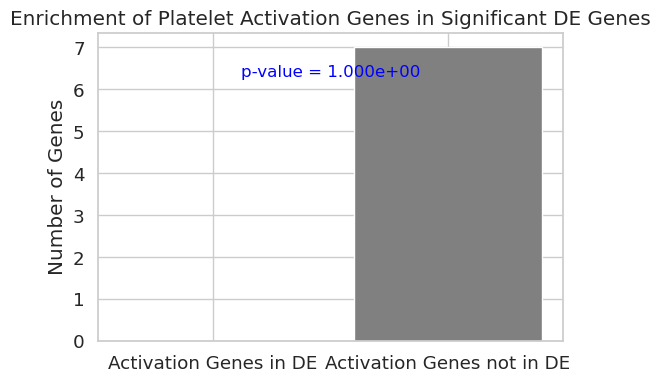

In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

# Ensure that the necessary objects and columns exist
if 'covid_de_df' not in globals():
    raise ValueError('covid_de_df not found. Ensure that the differential expression analysis has been previously executed.')

required_cols = ['names', 'logfoldchanges', 'pvals_adj']
for col in required_cols:
    if col not in covid_de_df.columns:
        raise ValueError(f"Required column '{col}' missing from covid_de_df.")

if 'platelet_adata' not in globals():
    raise ValueError('platelet_adata is not in memory. Ensure that Platelet cells have been subset from adata.')

# Set significance thresholds with biological relevance justification
pval_threshold = 0.05  # adjusted p-value threshold to control for multiple testing
lfc_threshold = 0.5    # absolute log fold change threshold to capture biologically meaningful changes

# Filter the DE results to obtain significantly DE genes
sig_de_genes = covid_de_df[(covid_de_df['pvals_adj'] < pval_threshold) & (covid_de_df['logfoldchanges'].abs() > lfc_threshold)]
sig_gene_list = set(sig_de_genes['names'])
print(f"Number of significant DE genes (COVID vs Healthy): {len(sig_gene_list)}")

# Define a flexible, curated set of genes involved in platelet activation and coagulation
platelet_activation_genes = set(['PF4', 'PPBP', 'TUBB1', 'ITGA2B', 'ITGB3', 'GP9', 'GP1BA'])

# Verify that the curated genes exist in the dataset
if not hasattr(platelet_adata, 'var_names'):
    raise ValueError('platelet_adata does not have proper var_names information.')

existing_activation_genes = platelet_activation_genes.intersection(set(platelet_adata.var_names))
print(f"Platelet activation genes present in the dataset: {existing_activation_genes}")

# Identify the overlap of curated pathway genes with significant DE genes
overlap_genes = existing_activation_genes.intersection(sig_gene_list)
print(f"Activation pathway genes found among significant DE genes: {overlap_genes}")

# Prepare parameters for the hypergeometric test
M = len(platelet_adata.var_names)  # total number of genes (background)
n = len(existing_activation_genes)  # number of curated pathway genes present in the dataset
N = len(sig_gene_list)             # number of significant DE genes
k = len(overlap_genes)             # number of overlapping genes

print(f"Background gene count (M): {M}")
print(f"Curated activation gene count (n): {n}")
print(f"Significant DE gene count (N): {N}")
print(f"Overlap count (k): {k}")

# Compute the hypergeometric p-value (probability of k or more successes)
p_value = hypergeom.sf(k - 1, M, n, N)
print(f"Hypergeometric test p-value for enrichment: {p_value:.3e}")

# Visualize the enrichment results using a bar plot with annotations
groups = ['Activation Genes in DE', 'Activation Genes not in DE']
counts = [k, n - k]

plt.figure(figsize=(6, 4))
bars = plt.bar(groups, counts, color=['red', 'grey'])
plt.ylabel('Number of Genes')
plt.title('Enrichment of Platelet Activation Genes in Significant DE Genes')
plt.text(0.5, max(counts) * 0.9, f'p-value = {p_value:.3e}', ha='center', fontsize=12, color='blue')
plt.show()

### Agent Interpretation

The results of the current analysis do not show any enrichment of platelet activation genes among the significantly differentially expressed (DE) genes between COVID-19 patients and healthy controls. The hypergeometric test yielded a p-value of 1.000, indicating no significant overlap.

**Feedback and Suggestions:**

1. **Assessment of Hypothesis:**
   - The hypothesis regarding platelet activation gene enrichment in DE genes between COVID-19 patients and healthy individuals is not supported by the current results.

2. **Biological Context:**
   - Given the research paper and past analyses, it's clear that the focus is on immune dysregulation. The lack of platelet activation gene enrichment suggests that platelet activation may not play a central role in the immune response or communication pathways being studied here.

3. **Future Steps:**
   - **Reassess Gene Set:** Ensure that the curated list of platelet activation genes is comprehensive and relevant to the specific context of COVID-19. Consider consulting additional databases or literature for potential updates.
   - **Explore Other Pathways:** Since platelet activation did not show enrichment, it might be worthwhile to explore other pathways or gene sets more directly related to monocyte and T cell interactions, cytokine responses, or interferon signaling.
   - **Broaden Analysis Scope:** Perform similar enrichment analyses with other functional gene sets, such as cytokine signaling, interferon-stimulated genes, or antigen presentation pathways. This might uncover other biologically relevant features.
   - **Subpopulation Analysis:** Perform the analysis on specific cell subpopulations, especially monocytes and T cells, where dysregulated cell communication was hypothesized. This might reveal more nuanced patterns not visible at the broader level.

4. **Replication and Robustness:**
   - Conduct repeats of the analysis under varied conditions, such as different thresholds for defining DE genes, to ensure robustness of results.
   - Validate findings using independent datasets or additional experimental approaches, such as proteomics, to determine the significance of platelet-related pathways in severe COVID-19.

These steps can help refine the analysis, uncover potentially significant pathways, and guide subsequent experiments in understanding the immune dysregulation in severe COVID-19.

## This code first subsets the full anndata object into monocyte and T cell groups based on cell type and disease Status, adding precautions to handle empty subsets. Then, for each predefined ligand-receptor pair, it extracts gene expression, computes summary statistics, performs t-tests, and visualizes the comparisons with bar plots.

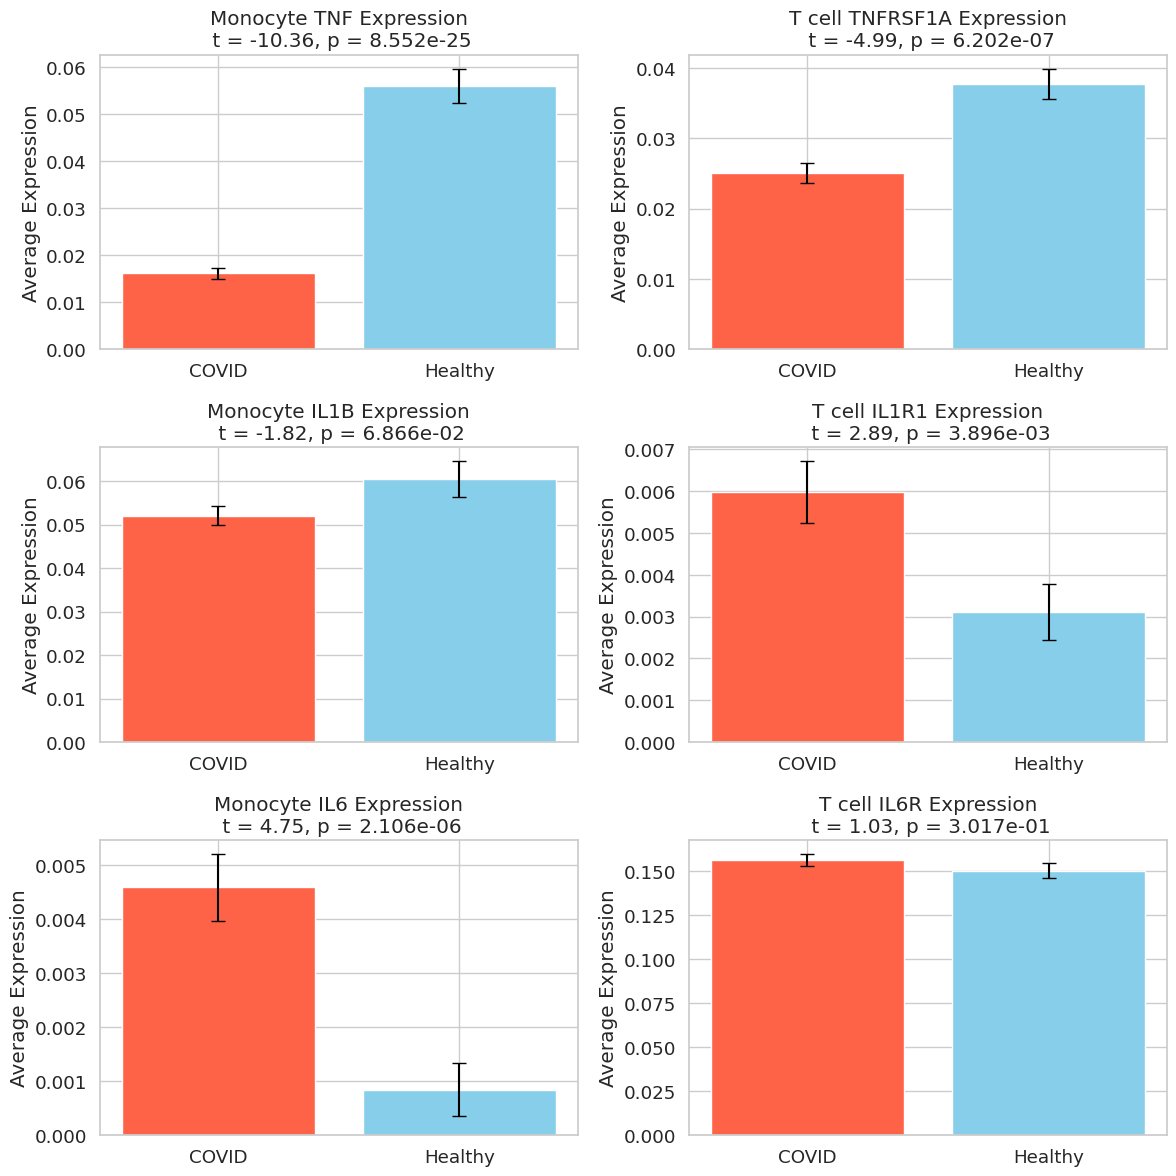

TNF (monocytes): t = -10.36, p = 8.552e-25
TNFRSF1A (T cells): t = -4.99, p = 6.202e-07

IL1B (monocytes): t = -1.82, p = 6.866e-02
IL1R1 (T cells): t = 2.89, p = 3.896e-03

IL6 (monocytes): t = 4.75, p = 2.106e-06
IL6R (T cells): t = 1.03, p = 3.017e-01



In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Define candidate ligand-receptor pairs
ligands = ['TNF', 'IL1B', 'IL6']
receptors = ['TNFRSF1A', 'IL1R1', 'IL6R']

# Subset adata to obtain monocytes and T cells based on 'cell_type_coarse'
monocyte_types = ['CD14 Monocyte', 'CD16 Monocyte']
t_cell_types = ['CD4 T', 'CD8 T']

monocytes = adata[adata.obs['cell_type_coarse'].isin(monocyte_types)].copy()
T_cells = adata[adata.obs['cell_type_coarse'].isin(t_cell_types)].copy()

# Further split each subset by Status with checks for empty subsets
if monocytes.n_obs == 0:
    raise ValueError('No monocyte cells found in the dataset.')
if T_cells.n_obs == 0:
    raise ValueError('No T cell cells found in the dataset.')

monocytes_covid = monocytes[monocytes.obs['Status'] == 'COVID'].copy()
monocytes_healthy = monocytes[monocytes.obs['Status'] == 'Healthy'].copy()

if monocytes_covid.n_obs == 0 or monocytes_healthy.n_obs == 0:
    raise ValueError('Empty monocyte subset for one of the Status conditions (COVID/Healthy).')

T_cells_covid = T_cells[T_cells.obs['Status'] == 'COVID'].copy()
T_cells_healthy = T_cells[T_cells.obs['Status'] == 'Healthy'].copy()

if T_cells_covid.n_obs == 0 or T_cells_healthy.n_obs == 0:
    raise ValueError('Empty T cell subset for one of the Status conditions (COVID/Healthy).')

# Function to extract gene expression as a flattened numpy array, with check for gene existence

def get_expr(adata_obj, gene):
    if gene not in adata_obj.var_names:
        raise ValueError(f"Gene {gene} not found in the dataset.")
    expr = adata_obj[:, gene].X
    if hasattr(expr, 'toarray'):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    return expr

# Prepare figure for visualization: 3 rows (one per candidate pair) x 2 columns (ligand in monocytes, receptor in T cells)
n_pairs = len(ligands)
fig, axes = plt.subplots(n_pairs, 2, figsize=(12, 4 * n_pairs))
if n_pairs == 1:
    axes = np.array([axes])  # Ensure axes is 2D even for one pair

# Loop over each candidate ligand-receptor pair
# This loop extracts expression values, computes summary statistics, performs t-tests (noting that nonparametric tests may be considered for single-cell data), and plots the group comparisons.
stat_results = []

for i, (ligand, receptor) in enumerate(zip(ligands, receptors)):
    # For monocytes: ligand expression
    expr_mono_covid = get_expr(monocytes_covid, ligand)
    expr_mono_healthy = get_expr(monocytes_healthy, ligand)
    
    mean_covid = np.mean(expr_mono_covid)
    mean_healthy = np.mean(expr_mono_healthy)
    se_covid = np.std(expr_mono_covid) / np.sqrt(len(expr_mono_covid))
    se_healthy = np.std(expr_mono_healthy) / np.sqrt(len(expr_mono_healthy))
    
    t_stat_lig, p_val_lig = ttest_ind(expr_mono_covid, expr_mono_healthy, equal_var=False)
    
    # Plot bar plot for ligand in monocytes
    ax_lig = axes[i, 0]
    groups = ['COVID', 'Healthy']
    means = [mean_covid, mean_healthy]
    ses = [se_covid, se_healthy]
    ax_lig.bar(groups, means, yerr=ses, capsize=5, color=['tomato', 'skyblue'])
    ax_lig.set_title(f"Monocyte {ligand} Expression\n t = {t_stat_lig:.2f}, p = {p_val_lig:.3e}")
    ax_lig.set_ylabel('Average Expression')
    
    # For T cells: receptor expression
    expr_T_covid = get_expr(T_cells_covid, receptor)
    expr_T_healthy = get_expr(T_cells_healthy, receptor)
    
    mean_covid_T = np.mean(expr_T_covid)
    mean_healthy_T = np.mean(expr_T_healthy)
    se_covid_T = np.std(expr_T_covid) / np.sqrt(len(expr_T_covid))
    se_healthy_T = np.std(expr_T_healthy) / np.sqrt(len(expr_T_healthy))
    
    t_stat_rec, p_val_rec = ttest_ind(expr_T_covid, expr_T_healthy, equal_var=False)
    
    # Plot bar plot for receptor in T cells
    ax_rec = axes[i, 1]
    groups = ['COVID', 'Healthy']
    means_rec = [mean_covid_T, mean_healthy_T]
    ses_rec = [se_covid_T, se_healthy_T]
    ax_rec.bar(groups, means_rec, yerr=ses_rec, capsize=5, color=['tomato', 'skyblue'])
    ax_rec.set_title(f"T cell {receptor} Expression\n t = {t_stat_rec:.2f}, p = {p_val_rec:.3e}")
    ax_rec.set_ylabel('Average Expression')
    
    # Save statistics for later reference
    stat_results.append({
        'ligand': ligand,
        'monocyte_t_stat': t_stat_lig,
        'monocyte_p_value': p_val_lig,
        'receptor': receptor,
        'T_cell_t_stat': t_stat_rec,
        'T_cell_p_value': p_val_rec
    })

plt.tight_layout()
plt.show()

# Print summary of statistical tests
for res in stat_results:
    print(f"{res['ligand']} (monocytes): t = {res['monocyte_t_stat']:.2f}, p = {res['monocyte_p_value']:.3e}")
    print(f"{res['receptor']} (T cells): t = {res['T_cell_t_stat']:.2f}, p = {res['T_cell_p_value']:.3e}\n")

### Agent Interpretation

The current analysis focuses on evaluating the differential gene expression of cytokines and their receptors between severe COVID-19 patients and healthy controls, specifically examining interactions between monocytes and T cells. Here's some feedback:

1. **TNF and TNFRSF1A Results:**
   - **Monocytes:** Significant downregulation of TNF in COVID-19 patients (t = -10.36, p = 8.552e-25) suggests that contrary to the hypothesis, TNF production by monocytes is decreased.
   - **T cells:** Similarly, TNFRSF1A is significantly downregulated in T cells from COVID-19 patients (t = -4.99, p = 6.202e-07).
   - **Interpretation:** These results do not support the hypothesis of enhanced TNF signaling between monocytes and T cells. Explore compensatory mechanisms or alternative signaling pathways that might be contributing to the inflammatory response.

2. **IL1B and IL1R1 Results:**
   - **Monocytes:** The expression of IL1B is not significantly different (t = -1.82, p = 6.866e-02), suggesting limited involvement of monocyte-derived IL1B in COVID-19 pathology, according to this analysis.
   - **T cells:** IL1R1 expression is significantly upregulated in COVID-19 patients (t = 2.89, p = 3.896e-03), indicating potential receptor upregulation that could be explored further for functional relevance.

3. **IL6 and IL6R Results:**
   - **Monocytes:** IL6 is significantly upregulated in COVID-19 patients (t = 4.75, p = 2.106e-06), supporting the hypothesis of monocyte contribution to inflammation.
   - **T cells:** IL6R is not significantly different (t = 1.03, p = 3.017e-01), indicating receptor expression on T cells might not be as responsive to COVID-19 induced changes.
   - **Considerations:** Follow-up with functional assays or protein-level verification to ascertain if increased IL6 leads to downstream signaling effects despite unchanged receptor levels.

**Further Steps:**

1. **Pathway Analysis:** Conduct pathway enrichment analyses to understand the broader biological processes affected in severe COVID-19, considering the unexpected downregulation of TNF and TNFRSF1A.

2. **Integration with Previous Results:** Combine with RNA velocity or pseudotime analyses to understand dynamic immune cell changes in relation to cytokine-receptor expression patterns.

3. **Alternative Cell-Cell Interactions:** Investigate additional ligand-receptor pairs or cellular interactions that might play roles in immunopathology, especially given the discrepancies with expected results.

4. **Functional Validation:** Validate findings through additional experiments, such as cytokine secretion assays, to confirm whether mRNA levels translate into functional protein differences.

These insights can refine the understanding of cytokine signaling dynamics in COVID-19 and reveal alternative pathways relevant to therapeutic strategies.